# Effects of User Type on Bike Use in the Ford GoBike Sharing System
## by Chisom Urom

## Investigation Overview

In this investigation, I looked at the features affecting the rate of bike use in the Ford GoBike Sharing System. The focus attributes were the user-type, duration per ride, the time of day and the day of the week. 


## Dataset Overview

The dataset consisted of 174, 952 individual bike rides to and from different stations with 9 variables describing the features of the each ride. 
The variables include the birth year of the user, user-type, date and time of each ride, start and end station names, bike id and user gender.

The dataset was also divided into two tables to conform with tidiness standards. The `trip` table contains information on the each trip taken by a user, while the `user` table carries information about the user on each trip. 8, 460 rows were dropped due to missing values.


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# read csv file into a pandas dataframe
bike_df = pd.read_csv('201902-fordgobike-tripdata.csv')

### Assessing and Cleaning Issues <a id=topic2></a>
- Max value for `duration_sec` appears outrageous (about 23 hours)
- Incorrect Datatypes for `start_time` and `end_time` columns
- Missing values in `member_birth_year`, `member_gender`, `start_station_name`, and `end_station_name` columns
- Some columns in the dataset are extraneous
- Columns of different observations unit types in one table

In [3]:
# make a copy of the dataframe before cleaning
bike = bike_df.copy()

### Define
Correct the datatypes for the start_time and end_time columns

In [4]:
# convert the datatypes to datetime
bike['start_time'] = pd.to_datetime(bike['start_time'])
bike['end_time'] = pd.to_datetime(bike['end_time'])

### Define 

Drop rows with missing values

In [5]:
bike.dropna(inplace =True)

### Define
Remove columns from dataset that wouldn't be necessary for our analysis

In [6]:
# drop the unnecessary columns
ext_columns = ['start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_latitude', 'end_station_longitude', 'bike_share_for_all_trip']
bike.drop(columns=ext_columns, inplace=True)

### Define
Create a table for the user's info and one for the trip information

In [7]:
# create a dataframe for the user's information
user_list = ['bike_id', 'user_type', 'member_birth_year', 'member_gender']
user = bike[user_list]

# create dataframe for the bike trip info
trip_list = ['bike_id', 'duration_sec', 'start_time', 'end_time', 'start_station_name', 'end_station_name']
trip = bike[trip_list]

In [8]:
# first, create columns to record the day and month names for each ride from start_time column
trip['day_name'] = trip.start_time.dt.day_name()
trip['month_name'] = trip.start_time.dt.month_name()

# next, order the day_name and month_name columns in categorical format
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
def make_category(df, ordering):
    '''quick function to make order for ordinal categorical variables'''
    set_order = pd.api.types.CategoricalDtype(ordered=True, categories=ordering)
    return df.astype(set_order)
trip.day_name = make_category(trip.day_name, day_order)
trip.month_name = make_category(trip.month_name, month_order)

In [9]:
plt.rcParams['figure.figsize'] = (8,6)
colour = sns.color_palette()[0]

## User Population by Types

Subscribers were the most number of users on the bike share system by a head count. Subscribers were infact more than 5 times the number of Customer type users that used the bikes. This takes into account just the number of trips each user type made with the bike.

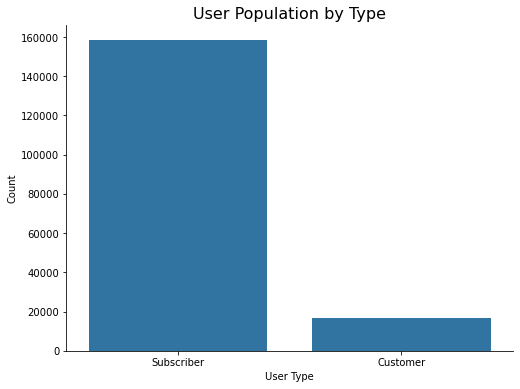

In [10]:
sns.countplot(data = user, x='user_type', color = colour, order = user.user_type.value_counts().index)
plt.xlabel('User Type')
plt.ylabel('Count')
plt.title('User Population by Type', fontsize=16)
sns.despine();

## Distribution of Trip Duration

Each trip duration was measured in seconds and took on quite a wide range of values. The duration ranged from around 60 seconds at its lowest to above to 80, 000 seconds for the highest durations. Plotted on a logarithmic scale, the distribution of duration takes a unimodal shape.

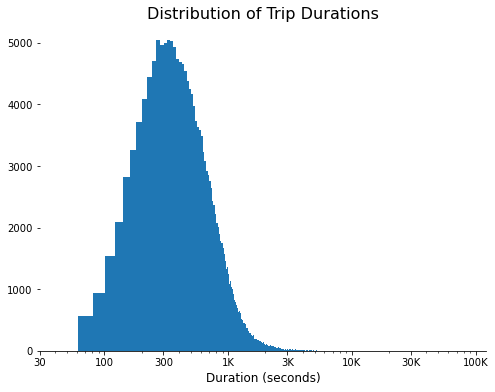

In [11]:
bins = np.arange(61, 84548+20, 20)
ticks = [30, 100, 300, 1e3, 3e3, 1e4, 3e4, 1e5]
tick_text = ['30', '100', '300', '1K', '3K', '10K', '30K', '100K']
plt.hist(data = trip, x= 'duration_sec', bins=bins)
plt.xscale('log')
plt.xlabel('Duration (seconds)', fontsize = 12)
plt.xticks(ticks, tick_text)
plt.title('Distribution of Trip Durations', fontsize = 16)
sns.despine(top=True, right=True, left=True);

## Average Duration by User type

Customers had a higher duration of use against Subscribers on average. This happens despite the Subscriber population being far greater than the Customers.

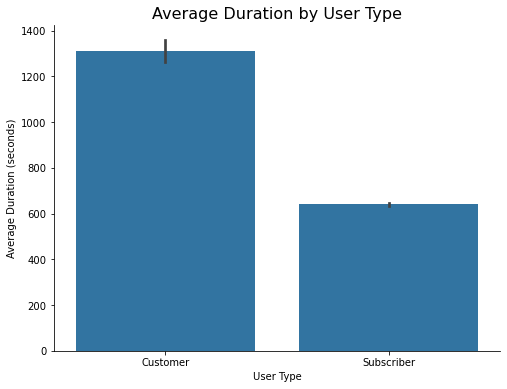

In [12]:
# use a barplot to show mean duration for each user type
sns.barplot(x=user.user_type, y=trip.duration_sec, color=colour)
plt.xlabel('User Type')
plt.ylabel('Average Duration (seconds)')
plt.title('Average Duration by User Type', fontsize=16)
sns.despine();

## Daily Use for User Type per Week

Subscribers apparently had the higher amount of use for each day of the week, but the pattern seemed to decline rapidly over the weekends. Thursday was the most active day of the week among both user types, but Customers did not experience the sharp decline weekend activity as did Subscribers. This pattern among subscribers suggest dedicated use of the bike share system for specific purposes on weekdays such as work.

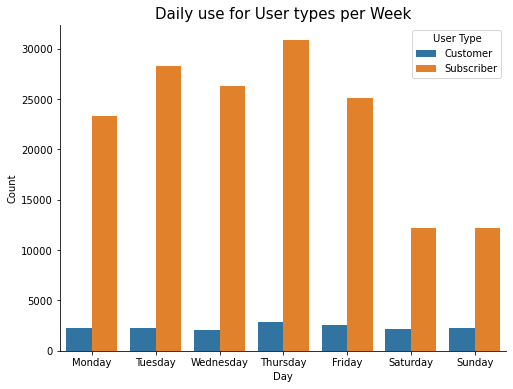

In [13]:
# create a table containing the day_name and usertype variables to plot together
user_day = trip[['day_name']]
user_day = user_day.join(user.user_type)
sns.countplot(data=user_day, x='day_name', hue='user_type')
plt.title('Daily use for User types per Week', fontsize=15)
plt.xlabel('Day')
plt.ylabel('Count')
plt.legend(title='User Type')
sns.despine();

## Hour of Day by User type
The peak hours of bike usage are clearly shown to be around the 8th and 17th hours of the day in a 24 hour time order.
The busiest hour was the 17th hour of the day, which reinforces the suggestion that more sunscribers were used the bike share system to cummute to work. Customers shared a similar pattern of hourly usage, but had a more uniform variation than Subscrbers during off-peak hours. The amount of usage declined steadily beyond the 20th hour and was rarely used in the first 5 hour of the day.

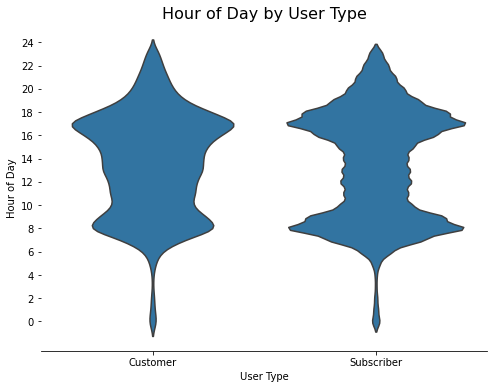

In [14]:
# create hour variable from ride start time
trip['hour'] = trip.start_time.dt.hour

# make a violin plot for the hour usage by users
ticks = np.arange(0, 25+1, 2)
df = pd.DataFrame(user['user_type']).join(pd.DataFrame(trip.hour))
sns.violinplot(data = df, x='user_type', y='hour', color=colour, inner=None)

plt.xlabel('User Type')
plt.ylabel('Hour of Day')
plt.title('Hour of Day by User Type', fontsize=16)
plt.yticks(ticks, ticks)
sns.despine(top=True, right=True, left=True);

## Gender and Age by User type

Gender and age seemed to have a surface influence on the overall usage of the bike share system. Neither gender nor age had a pronounced impact on whether users chose to Subscribe or not. Generally, there were more males than any other gender, but the proportion of Subscribed males to Customers in the male gender was similar to the proportion across the other genders. Also, younger people around the ages 20 to 60 made up the user population and didn't directly favor the choice of a user to subscribe.

In [15]:
# calculate age of each user at time of usage
user_age = trip.start_time.dt.year.unique()[0] -  user.member_birth_year 

# add the user_age series as a column in the user dataframe
user['age'] = user_age

# drop the birth_year column for tidiness
user.drop(columns=['member_birth_year'], inplace=True)

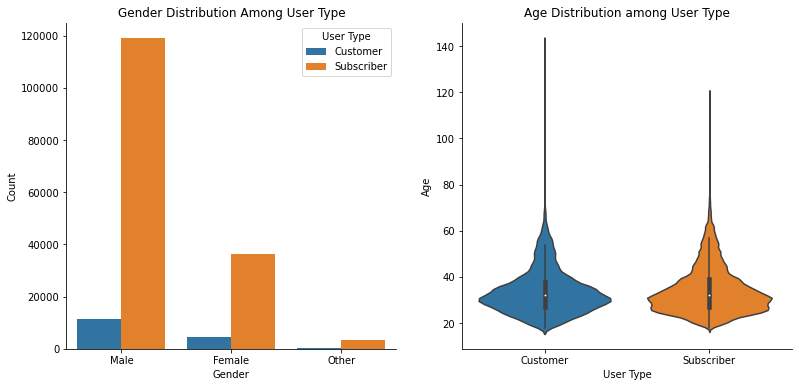

In [16]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
# make a plot to visualise number of user types for each gender
sns.countplot(data = user, x = 'member_gender', hue='user_type', order = user.member_gender.value_counts().index)
plt.title('Gender Distribution Among User Type')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='User Type')

plt.subplot(1,2,2)
# make plot for the age distribution for each user type
sns.violinplot(data=user, x='user_type', y='age')
plt.xlabel('User Type')
plt.ylabel('Age')
plt.title('Age Distribution among User Type')
sns.despine();

## Hour of Day by Day of Week and User type

We can see how the rate of bike use has a consistent pattern fo all weekdays but not the weekends. During the week days, peak hours were the 8th and 17 hour of the day, but this wasn't same during weekends. Saturday and Sunday had slightly more usage among Customer type user than Subscribers and the peak hour was about the 14th hour of the day.

It is also evident how Cutomers have more use during off peak hours on week day than Subscribers.

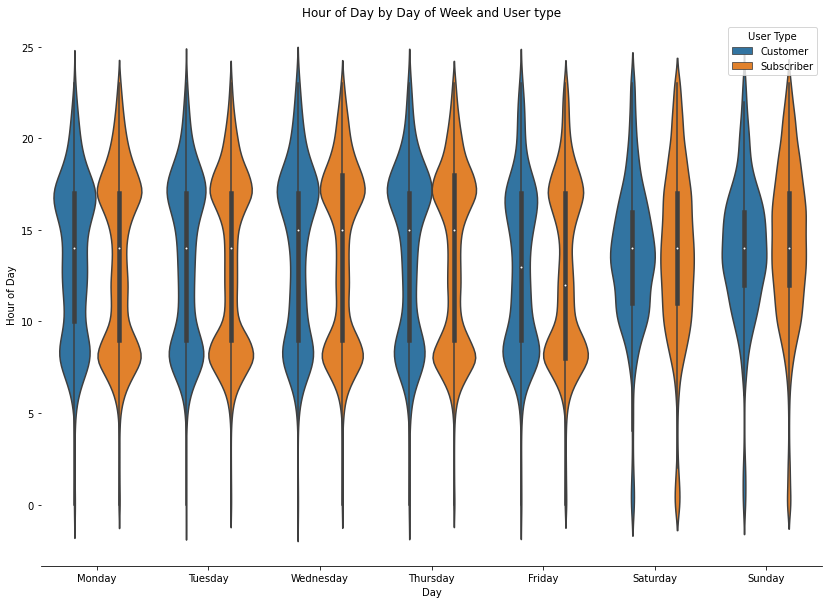

In [17]:
plt.figure(figsize=(14,10))
df = trip[['day_name', 'hour']].join(user.user_type)

sns.violinplot(data = df, x='day_name', y='hour', hue='user_type')
plt.legend(title='User Type',loc=1)
plt.title('Hour of Day by Day of Week and User type')
plt.ylabel('Hour of Day')
plt.xlabel('Day')
sns.despine(top=True, right=True, left=True);

## Day of Week by Ride Duration and User Type

This shows that Subcribers took most of their trips during the weekdays, but more importantly, Subscribers had more medium and short duration trips than long ones. I categorized the trip durations into three groups in the following order:

- Miniumum duration to first quartile = `Short`
- First Quartile to third quartile = `Medium`
- Third quartile to maximum duration = `Long`

While Customer type users mostly used the bike share system for medium and long duration trips, there wasn't however a decline during the weekend. Rather, either day in the weekend had more long duration trips than any other weekday. Thursday remained the busiest day in the week for both user types. The impact of longer duration trips by more Customers and shorter durations by more Subscirbers indicates the reason for Customers having a higher trip duration on average.

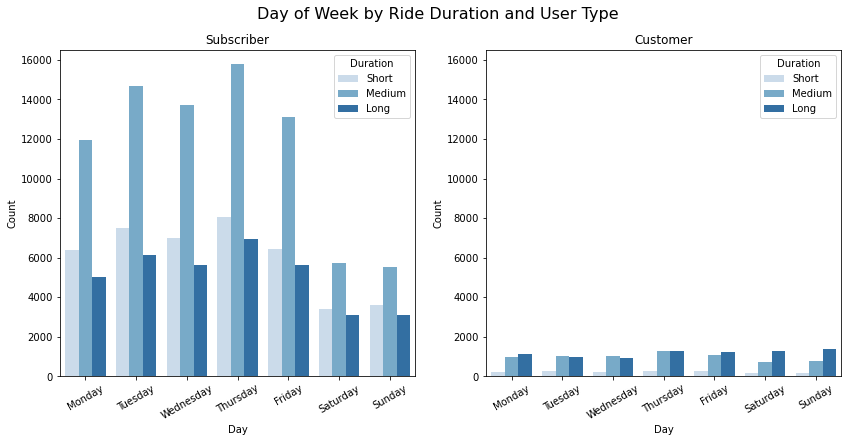

In [18]:
# create categories for the duration variable
# bin size between ranges from the minimun duration, through the first, third and fourth quartile
minimum = trip.duration_sec.min()
median = trip.duration_sec.quantile(0.25)
quartile_3 = trip.duration_sec.quantile(0.75)
maximum = trip.duration_sec.max()
bin_size = [minimum, median, quartile_3, maximum]
label = ['Short', 'Medium', 'Long']
aband = trip.duration_sec.dropna()
trip['timing'] = pd.cut(aband, bins=bin_size, labels=label)

# create a sub-dataframe for the variabels to plot
df = trip[['day_name', 'timing']].join(user.user_type)

# create the plots for each user type
plt.figure(figsize=(14,6))
users = ['Subscriber', 'Customer']
for num in range(len(users)):
    subdata = df[df.user_type == users[num]]
    plt.subplot(1,2,num+1)
    sns.countplot(data = subdata, x='day_name', hue='timing', palette='Blues')
    plt.xticks(rotation=30)
    plt.title(users[num])
    plt.legend(title='Duration')
    plt.ylim(0,16500)
    plt.xlabel('Day')
    plt.ylabel('Count')
plt.suptitle('Day of Week by Ride Duration and User Type', fontsize=16);

## Key Insights

The key insights from this presentation can be summarised as follows:

- The bike share service had more use by Subscribers but Customers type users has a higher average duration on trips.
- Thursday was the busiest day of the week for both Subscribers and Customers.
- Subscribers mostly used the bike share system at peak hours during the week days (at the 8th and 17th hour), while customers had a slightly more balanced used for different hour of the day.
- Weekend had a sudden decline in usage by subscribers and the peak hour became around the 14th hour of the day.
- Customer type users took more long duration trips than Subscribers. Even during the weekends, more customers took even more medium and long duration trips.
- Subscribers took more short and medium duration trips than long durations and mostly during weekdays.

In [20]:
# convert notebook to slides
!jupyter nbconvert slidedeck_ford_gobike_analysis.ipynb --to slides --post serve --no-input --no-prompt

^C
